# Carrega i Exploració inicial

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [21]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/GoogleColab/')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Descarrega.ipynb
DL
Entrega.ipynb
genre_analysis.csv
steam_achievements_complete_20250528_214709.csv
steam_achievements_dashboard.html
steam_combined_data.csv
steam_games.csv
steam_processed_for_viz.csv
steam_reviews_progress.csv


Estructura dels datasets:
Jocs: (71429, 21)
Assoliments: (1156256, 11)

Columnes del dataset de jocs:
['steam_appid', 'name', 'developers', 'publishers', 'categories', 'genres', 'required_age', 'n_achievements', 'platforms', 'is_released', 'release_date', 'additional_content', 'total_reviews', 'total_positive', 'total_negative', 'review_score', 'review_score_desc', 'positive_percentual', 'metacritic', 'is_free', 'price_initial (USD)']

Columnes del dataset d'assoliments:
['steam_appid', 'game_name', 'achievement_name', 'achievement_percent', 'developers', 'publishers', 'categories', 'genres', 'required_age', 'n_achievements', 'platforms']

Primeres 3 files del dataset de jocs:
   steam_appid                  name           developers  \
0      2719580              勇者の伝説の勇者             ['ぽけそう']   
1      2719590         Light No Fire      ['Hello Games']   
2      2719600  Lorhaven: Cursed War  ['GoldenGod Games']   

            publishers                                         catego

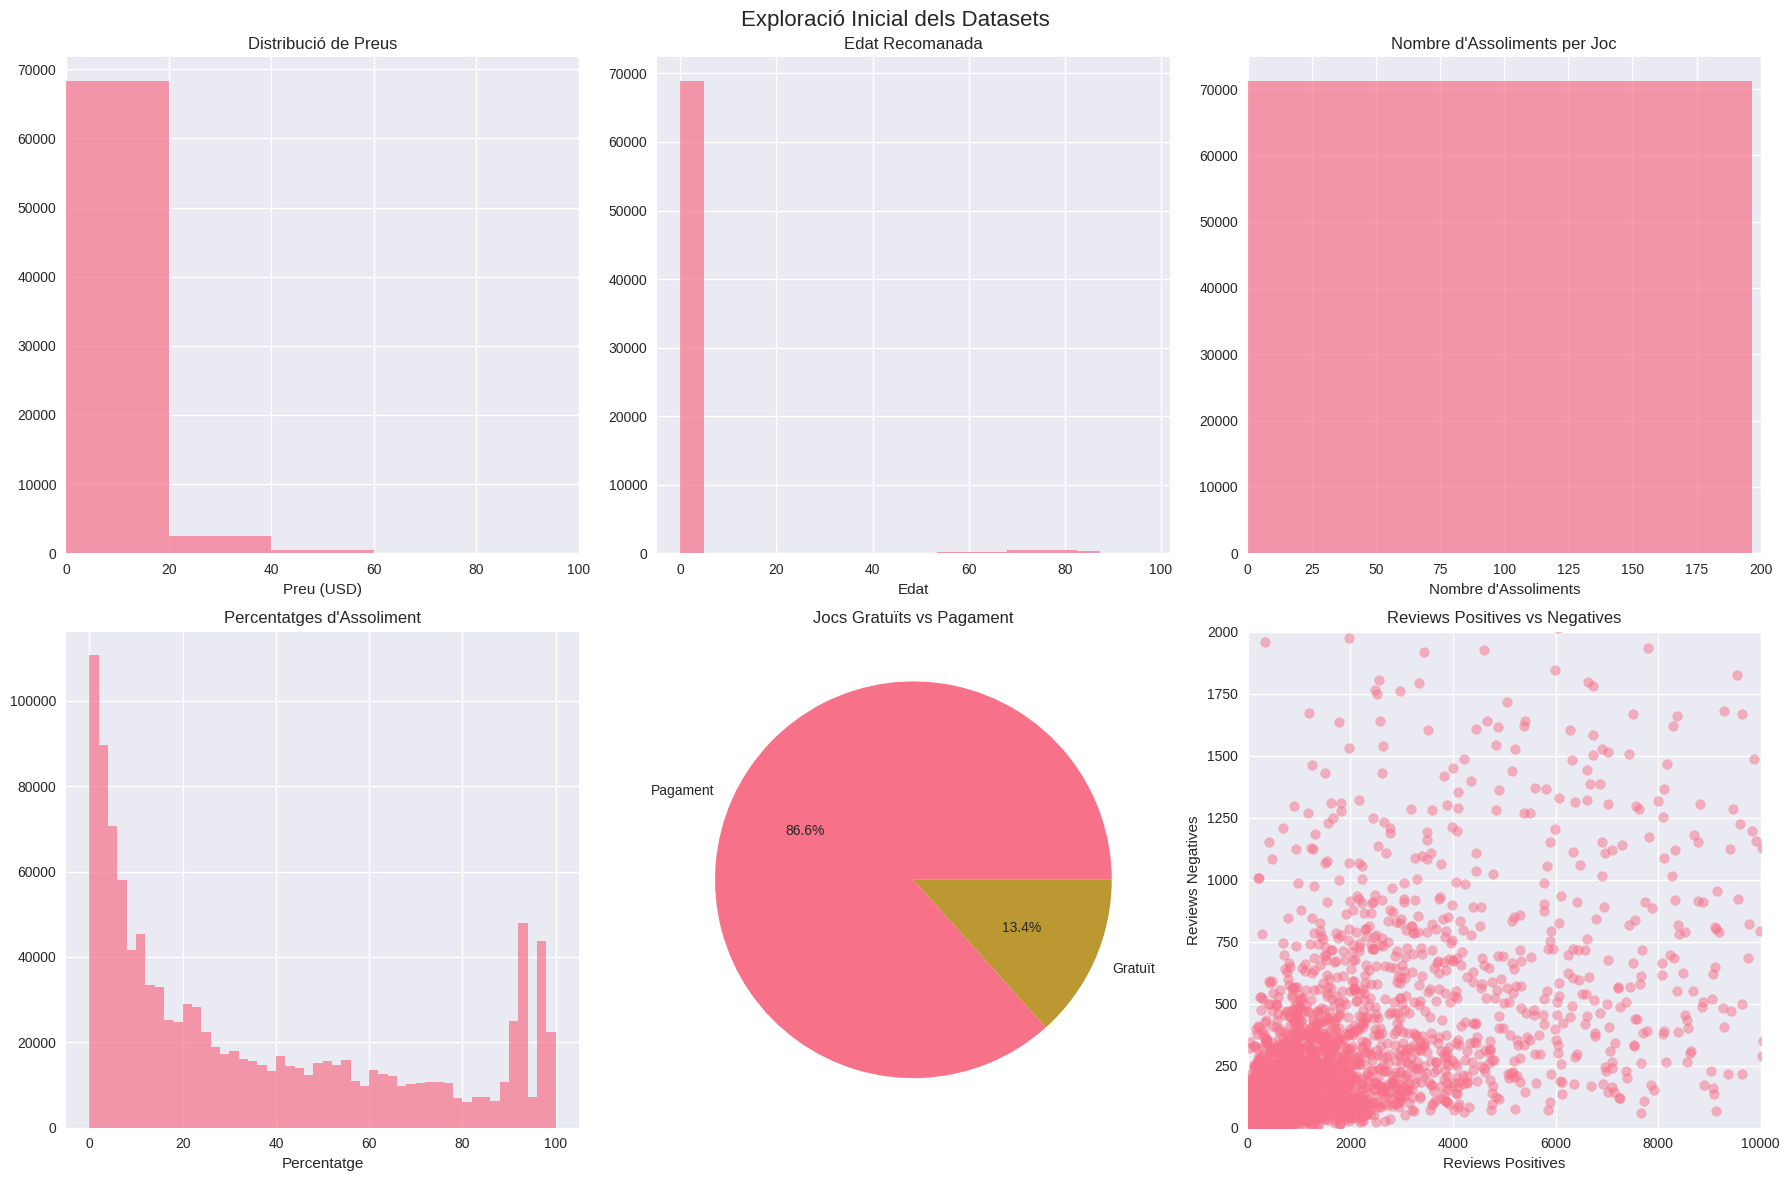


Resum exploració inicial completat.


In [22]:
# Càrrega dels datasets
df_games = pd.read_csv('steam_games.csv')
df_achievements = pd.read_csv('steam_achievements_complete_20250528_214709.csv')

print("Estructura dels datasets:")
print(f"Jocs: {df_games.shape}")
print(f"Assoliments: {df_achievements.shape}")

print("\nColumnes del dataset de jocs:")
print(list(df_games.columns))

print("\nColumnes del dataset d'assoliments:")
print(list(df_achievements.columns))

print("\nPrimeres 3 files del dataset de jocs:")
print(df_games.head(3))

print("\nPrimeres 3 files del dataset d'assoliments:")
print(df_achievements.head(3))

# Informació general
print("\nInformació general - Jocs:")
print(df_games.info())

print("\nInformació general - Assoliments:")
print(df_achievements.info())

# Estadístiques descriptives per columnes numèriques
print("\nEstadístiques descriptives - Jocs:")
numeric_cols = df_games.select_dtypes(include=[np.number]).columns
print(df_games[numeric_cols].describe())

print("\nEstadístiques descriptives - Assoliments:")
numeric_cols_ach = df_achievements.select_dtypes(include=[np.number]).columns
print(df_achievements[numeric_cols_ach].describe())

# Valors nuls
print("\nValors nuls - Jocs:")
print(df_games.isnull().sum()[df_games.isnull().sum() > 0])

print("\nValors nuls - Assoliments:")
print(df_achievements.isnull().sum()[df_achievements.isnull().sum() > 0])

# Visualització exploratòria inicial
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Exploració Inicial dels Datasets', fontsize=16)

# Distribució de preus
axes[0,0].hist(df_games['price_initial (USD)'], bins=50, alpha=0.7)
axes[0,0].set_title('Distribució de Preus')
axes[0,0].set_xlabel('Preu (USD)')
axes[0,0].set_xlim(0, 100)

# Distribució d'edat recomanada
axes[0,1].hist(df_games['required_age'], bins=20, alpha=0.7)
axes[0,1].set_title('Edat Recomanada')
axes[0,1].set_xlabel('Edat')

# Distribució de nombre d'assoliments per joc
axes[0,2].hist(df_games['n_achievements'], bins=50, alpha=0.7)
axes[0,2].set_title('Nombre d\'Assoliments per Joc')
axes[0,2].set_xlabel('Nombre d\'Assoliments')
axes[0,2].set_xlim(0, 200)

# Distribució de percentatges d'assoliment
axes[1,0].hist(df_achievements['achievement_percent'], bins=50, alpha=0.7)
axes[1,0].set_title('Percentatges d\'Assoliment')
axes[1,0].set_xlabel('Percentatge')

# Jocs gratuïts vs pagament
free_counts = df_games['is_free'].value_counts()
axes[1,1].pie(free_counts.values, labels=['Pagament', 'Gratuït'], autopct='%1.1f%%')
axes[1,1].set_title('Jocs Gratuïts vs Pagament')

# Reviews positives vs negatives
df_games_reviews = df_games[df_games['total_reviews'] > 0]
axes[1,2].scatter(df_games_reviews['total_positive'], df_games_reviews['total_negative'], alpha=0.5)
axes[1,2].set_title('Reviews Positives vs Negatives')
axes[1,2].set_xlabel('Reviews Positives')
axes[1,2].set_ylabel('Reviews Negatives')
axes[1,2].set_xlim(0, 10000)
axes[1,2].set_ylim(0, 2000)

plt.tight_layout()
plt.show()

print("\nResum exploració inicial completat.")

# Neteja de dades

In [23]:
# Funcions de neteja
def clean_genres(genre_string):
    """Neteja i normalitza la cadena de gèneres"""
    if pd.isna(genre_string) or genre_string == '[]':
        return []

    genre_str = str(genre_string)

    if genre_str.startswith("['"):
        try:
            import ast
            genres_list = ast.literal_eval(genre_str)
            return [g.strip() for g in genres_list if g and g.strip()]
        except:
            cleaned = genre_str.replace('[', '').replace(']', '').replace("'", '').replace('"', '')
            genres = [g.strip() for g in cleaned.split(',') if g.strip()]
            return genres
    else:
        genres = [g.strip() for g in genre_str.split(',') if g.strip()]
        return genres

def clean_categories(category_string):
    """Neteja i normalitza la cadena de categories"""
    if pd.isna(category_string) or category_string == '[]':
        return []

    category_str = str(category_string)

    if category_str.startswith("['"):
        try:
            import ast
            categories_list = ast.literal_eval(category_str)
            return [c.strip() for c in categories_list if c and c.strip()]
        except:
            cleaned = category_str.replace('[', '').replace(']', '').replace("'", '').replace('"', '')
            categories = [c.strip() for c in cleaned.split(',') if c.strip()]
            return categories
    else:
        categories = [c.strip() for c in category_str.split(',') if c.strip()]
        return categories

print("Neteja del dataset de jocs:")

# Eliminar duplicats per steam_appid
initial_games = len(df_games)
df_games = df_games.drop_duplicates(subset=['steam_appid'])
print(f"Jocs duplicats eliminats: {initial_games - len(df_games)}")

# Eliminar files amb valors nuls crítics
df_games = df_games.dropna(subset=['name', 'steam_appid'])
df_games['steam_appid'] = df_games['steam_appid'].astype(int)
print(f"Jocs després de neteja bàsica: {len(df_games)}")

# Aplicar neteja de gèneres i categories
df_games['genres_list'] = df_games['genres'].apply(clean_genres)
df_games['categories_list'] = df_games['categories'].apply(clean_categories)

# Verificar neteja de gèneres
print("\nExemples de neteja de gèneres:")
for i in range(3):
    original = df_games.iloc[i]['genres']
    cleaned = df_games.iloc[i]['genres_list']
    print(f"Original: {original}")
    print(f"Netejat: {cleaned}")
    print("---")

# Estadístiques de gèneres netejats
all_genres = []
for genres_list in df_games['genres_list']:
    all_genres.extend(genres_list)

genre_counts = pd.Series(all_genres).value_counts()
print(f"\nGèneres únics després de neteja: {len(genre_counts)}")
print("Top 10 gèneres més comuns:")
print(genre_counts.head(10))

# Estadístiques de categories netejades
all_categories = []
for categories_list in df_games['categories_list']:
    all_categories.extend(categories_list)

category_counts = pd.Series(all_categories).value_counts()
print(f"\nCategories úniques després de neteja: {len(category_counts)}")
print("Top 10 categories més comunes:")
print(category_counts.head(10))

print("\nNeteja del dataset d'assoliments:")

# Eliminar duplicats
initial_achievements = len(df_achievements)
df_achievements = df_achievements.drop_duplicates()
print(f"Assoliments duplicats eliminats: {initial_achievements - len(df_achievements)}")

# Eliminar valors nuls crítics
df_achievements = df_achievements.dropna(subset=['steam_appid', 'achievement_percent'])
df_achievements['steam_appid'] = df_achievements['steam_appid'].astype(int)
print(f"Assoliments després de neteja: {len(df_achievements)}")

# Verificar rang de percentatges
print(f"Rang de percentatges d'assoliment: {df_achievements['achievement_percent'].min():.2f}% - {df_achievements['achievement_percent'].max():.2f}%")

# Crear columnes derivades per jocs
df_games['num_genres'] = df_games['genres_list'].apply(len)
df_games['num_categories'] = df_games['categories_list'].apply(len)
df_games['has_achievements'] = df_games['n_achievements'] > 0

print(f"\nJocs amb assoliments: {df_games['has_achievements'].sum()}")
print(f"Jocs sense assoliments: {(~df_games['has_achievements']).sum()}")

print("\nNeteja completada. Datasets preparats per a l'anàlisi.")

Neteja del dataset de jocs:
Jocs duplicats eliminats: 0
Jocs després de neteja bàsica: 71429

Exemples de neteja de gèneres:
Original: ['Casual', 'Indie']
Netejat: ['Casual', 'Indie']
---
Original: ['Action', 'Adventure']
Netejat: ['Action', 'Adventure']
---
Original: ['RPG', 'Strategy']
Netejat: ['RPG', 'Strategy']
---

Gèneres únics després de neteja: 33
Top 10 gèneres més comuns:
Indie           50665
Action          30986
Adventure       29741
Casual          28093
Simulation      14611
RPG             14377
Strategy        14144
Early Access     7881
Free To Play     5998
Sports           2854
Name: count, dtype: int64

Categories úniques després de neteja: 42
Top 10 categories més comunes:
Single-player                 66917
Family Sharing                48816
Steam Achievements            33095
Full controller support       17135
Steam Cloud                   17120
Multi-player                  14226
Partial Controller Support     8999
PvP                            8833
Steam T

# Comparació Jocs amb/sense Assoliments

Comparació bàsica:
Jocs amb assoliments: 31533 (44.1%)
Jocs sense assoliments: 39896 (55.9%)

Comparació de mètriques clau:
                     Amb_Assoliments_Mitjana  Sense_Assoliments_Mitjana  \
price_initial (USD)                     9.19                       4.42   
required_age                            4.84                       0.78   
total_reviews                         797.97                     103.81   
positive_percentual                    65.84                      30.52   
num_genres                              2.87                       2.91   
num_categories                          5.19                       3.23   

                     Amb_Assoliments_Mediana  Sense_Assoliments_Mediana  
price_initial (USD)                     4.99                       0.99  
required_age                            0.00                       0.00  
total_reviews                          11.00                       0.00  
positive_percentual                    79.10          

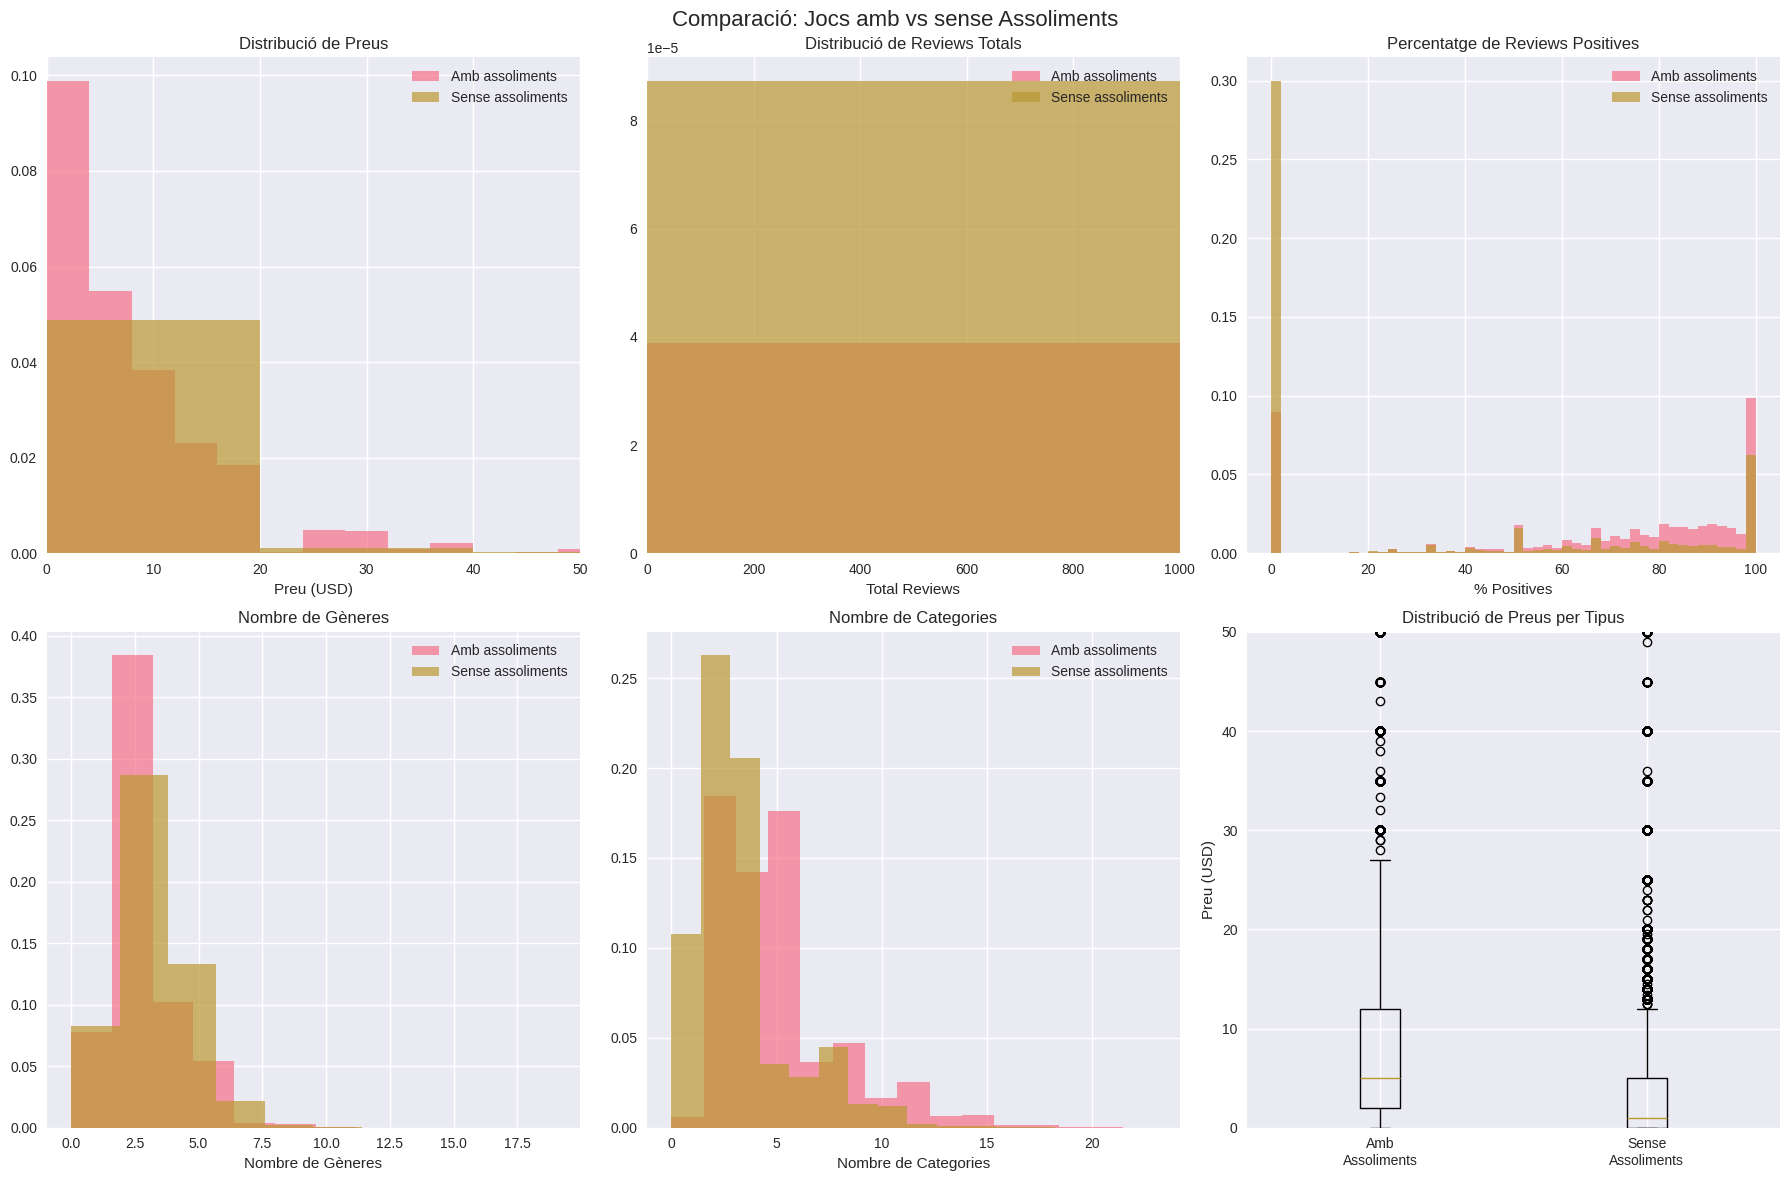


Tests estadístics (p-values):
Preu: 0.0
Reviews totals: 0.0
% Reviews positives: 0.0

Comparació completada.


In [24]:
# Separar jocs amb i sense assoliments
games_with_achievements = df_games[df_games['has_achievements']].copy()
games_without_achievements = df_games[~df_games['has_achievements']].copy()

print("Comparació bàsica:")
print(f"Jocs amb assoliments: {len(games_with_achievements)} ({len(games_with_achievements)/len(df_games)*100:.1f}%)")
print(f"Jocs sense assoliments: {len(games_without_achievements)} ({len(games_without_achievements)/len(df_games)*100:.1f}%)")

# Comparació de característiques principals
comparison_metrics = ['price_initial (USD)', 'required_age', 'total_reviews',
                     'positive_percentual', 'num_genres', 'num_categories']

comparison_results = pd.DataFrame({
    'Amb_Assoliments_Mitjana': games_with_achievements[comparison_metrics].mean(),
    'Sense_Assoliments_Mitjana': games_without_achievements[comparison_metrics].mean(),
    'Amb_Assoliments_Mediana': games_with_achievements[comparison_metrics].median(),
    'Sense_Assoliments_Mediana': games_without_achievements[comparison_metrics].median()
}).round(2)

print("\nComparació de mètriques clau:")
print(comparison_results)

# Comparació de jocs gratuïts vs pagament
print("\nDistribució de jocs gratuïts:")
free_with = games_with_achievements['is_free'].value_counts(normalize=True) * 100
free_without = games_without_achievements['is_free'].value_counts(normalize=True) * 100

print("Jocs amb assoliments:")
print(f"  Gratuïts: {free_with.get(True, 0):.1f}%")
print(f"  Pagament: {free_with.get(False, 0):.1f}%")

print("Jocs sense assoliments:")
print(f"  Gratuïts: {free_without.get(True, 0):.1f}%")
print(f"  Pagament: {free_without.get(False, 0):.1f}%")

# Anàlisi de gèneres
print("\nTop 10 gèneres en jocs amb assoliments:")
genres_with = []
for genres_list in games_with_achievements['genres_list']:
    genres_with.extend(genres_list)
genre_counts_with = pd.Series(genres_with).value_counts().head(10)
print(genre_counts_with)

print("\nTop 10 gèneres en jocs sense assoliments:")
genres_without = []
for genres_list in games_without_achievements['genres_list']:
    genres_without.extend(genres_list)
genre_counts_without = pd.Series(genres_without).value_counts().head(10)
print(genre_counts_without)

# Visualització de comparacions
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comparació: Jocs amb vs sense Assoliments', fontsize=16)

# Distribució de preus
axes[0,0].hist(games_with_achievements['price_initial (USD)'], bins=50, alpha=0.7, label='Amb assoliments', density=True)
axes[0,0].hist(games_without_achievements['price_initial (USD)'], bins=50, alpha=0.7, label='Sense assoliments', density=True)
axes[0,0].set_title('Distribució de Preus')
axes[0,0].set_xlabel('Preu (USD)')
axes[0,0].set_xlim(0, 50)
axes[0,0].legend()

# Distribució de reviews totals
axes[0,1].hist(games_with_achievements['total_reviews'], bins=50, alpha=0.7, label='Amb assoliments', density=True)
axes[0,1].hist(games_without_achievements['total_reviews'], bins=50, alpha=0.7, label='Sense assoliments', density=True)
axes[0,1].set_title('Distribució de Reviews Totals')
axes[0,1].set_xlabel('Total Reviews')
axes[0,1].set_xlim(0, 1000)
axes[0,1].legend()

# Percentatge de reviews positives
axes[0,2].hist(games_with_achievements['positive_percentual'], bins=50, alpha=0.7, label='Amb assoliments', density=True)
axes[0,2].hist(games_without_achievements['positive_percentual'], bins=50, alpha=0.7, label='Sense assoliments', density=True)
axes[0,2].set_title('Percentatge de Reviews Positives')
axes[0,2].set_xlabel('% Positives')
axes[0,2].legend()

# Nombre de gèneres
axes[1,0].hist(games_with_achievements['num_genres'], bins=10, alpha=0.7, label='Amb assoliments', density=True)
axes[1,0].hist(games_without_achievements['num_genres'], bins=10, alpha=0.7, label='Sense assoliments', density=True)
axes[1,0].set_title('Nombre de Gèneres')
axes[1,0].set_xlabel('Nombre de Gèneres')
axes[1,0].legend()

# Nombre de categories
axes[1,1].hist(games_with_achievements['num_categories'], bins=15, alpha=0.7, label='Amb assoliments', density=True)
axes[1,1].hist(games_without_achievements['num_categories'], bins=15, alpha=0.7, label='Sense assoliments', density=True)
axes[1,1].set_title('Nombre de Categories')
axes[1,1].set_xlabel('Nombre de Categories')
axes[1,1].legend()

# Boxplot de preus per tipus
data_for_box = [
    games_with_achievements['price_initial (USD)'].dropna(),
    games_without_achievements['price_initial (USD)'].dropna()
]
axes[1,2].boxplot(data_for_box, labels=['Amb\nAssoliments', 'Sense\nAssoliments'])
axes[1,2].set_title('Distribució de Preus per Tipus')
axes[1,2].set_ylabel('Preu (USD)')
axes[1,2].set_ylim(0, 50)

plt.tight_layout()
plt.show()

# Test estadístics simples
from scipy import stats

print("\nTests estadístics (p-values):")
print("Preu:", stats.mannwhitneyu(
    games_with_achievements['price_initial (USD)'].dropna(),
    games_without_achievements['price_initial (USD)'].dropna()
).pvalue)

print("Reviews totals:", stats.mannwhitneyu(
    games_with_achievements['total_reviews'].dropna(),
    games_without_achievements['total_reviews'].dropna()
).pvalue)

print("% Reviews positives:", stats.mannwhitneyu(
    games_with_achievements['positive_percentual'].dropna(),
    games_without_achievements['positive_percentual'].dropna()
).pvalue)

print("\nComparació completada.")

# Anàlisi Detallada dels Jocs amb Assoliments

Jocs amb dades d'assoliments: 31533

Distribució per categories de dificultat:
difficulty_category
Molt Difícil    10387
Difícil          9841
Moderat          6693
Fàcil            2892
Molt Fàcil       1694
Sense dades        26
Name: count, dtype: int64

Distribució per categories de nombre d'assoliments:
achievement_count_category
Moderats (11-30)     14610
Pocs (1-10)           8170
Molts (31-60)         6196
Moltíssims (60+)      2531
Sense assoliments       26
Name: count, dtype: int64

=== PREGUNTA 1: Tipus de jocs amb més assoliments ===
Top 10 gèneres amb més assoliments mitjans:
                    genre  avg_achievements  game_count
23               Strategy             53.13        6305
20             Simulation             48.18        6149
5                  Casual             46.67       13389
13  Massively Multiplayer             40.16         510
1                  Action             37.05       13749
17                    RPG             35.91        5878
12         

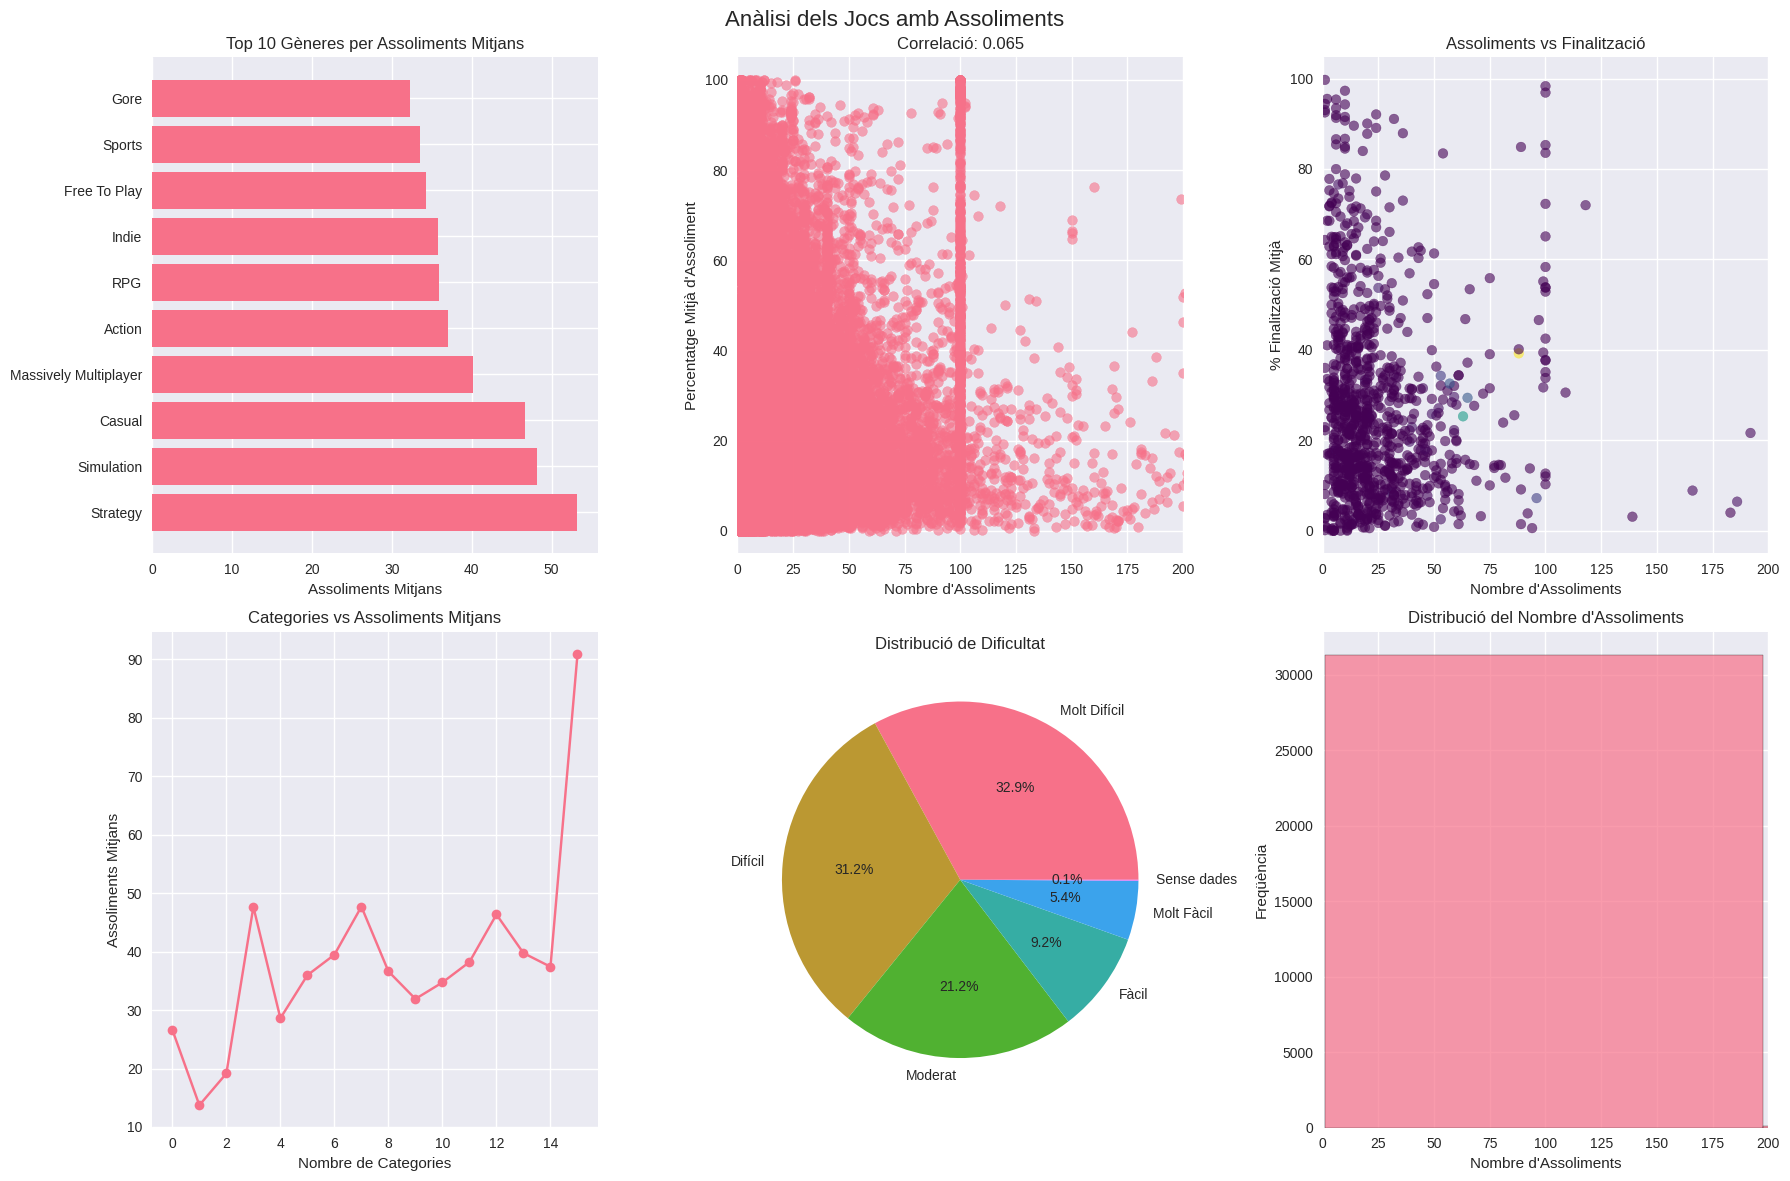


Anàlisi dels jocs amb assoliments completada.


In [29]:
# Bloc 4: Anàlisi Detallada dels Jocs amb Assoliments

# Calcular estadístiques d'assoliments per joc
achievement_stats = df_achievements.groupby('steam_appid').agg({
    'achievement_percent': ['count', 'mean', 'std', 'min', 'max']
}).round(2)

achievement_stats.columns = ['num_achievements', 'avg_achievement_percent',
                           'std_achievement_percent', 'min_achievement_percent',
                           'max_achievement_percent']
achievement_stats = achievement_stats.reset_index()

# Merge amb dataset de jocs
df_combined = games_with_achievements.merge(achievement_stats, on='steam_appid', how='left')

print(f"Jocs amb dades d'assoliments: {len(df_combined)}")

# Definir categories de dificultat i nombre d'assoliments
def categorize_difficulty(avg_percent):
    if pd.isna(avg_percent):
        return 'Sense dades'
    elif avg_percent >= 70:
        return 'Molt Fàcil'
    elif avg_percent >= 50:
        return 'Fàcil'
    elif avg_percent >= 30:
        return 'Moderat'
    elif avg_percent >= 15:
        return 'Difícil'
    else:
        return 'Molt Difícil'

def categorize_achievement_count(count):
    if pd.isna(count) or count == 0:
        return 'Sense assoliments'
    elif count <= 10:
        return 'Pocs (1-10)'
    elif count <= 30:
        return 'Moderats (11-30)'
    elif count <= 60:
        return 'Molts (31-60)'
    else:
        return 'Moltíssims (60+)'

df_combined['difficulty_category'] = df_combined['avg_achievement_percent'].apply(categorize_difficulty)
df_combined['achievement_count_category'] = df_combined['num_achievements'].apply(categorize_achievement_count)

print("\nDistribució per categories de dificultat:")
print(df_combined['difficulty_category'].value_counts())

print("\nDistribució per categories de nombre d'assoliments:")
print(df_combined['achievement_count_category'].value_counts())

# PREGUNTA 1: Tipus de jocs amb més assoliments
print("\n=== PREGUNTA 1: Tipus de jocs amb més assoliments ===")

genre_achievements = []
for idx, row in df_combined.iterrows():
    for genre in row['genres_list']:
        if genre and genre.strip():
            genre_achievements.append({
                'genre': genre.strip(),
                'num_achievements': row['num_achievements'],
                'avg_achievement_percent': row['avg_achievement_percent'],
                'steam_appid': row['steam_appid']
            })

df_genres = pd.DataFrame(genre_achievements)

genre_stats = df_genres.groupby('genre').agg({
    'num_achievements': ['mean', 'median', 'count'],
    'avg_achievement_percent': ['mean', 'median']
}).round(2)

genre_stats.columns = ['avg_achievements', 'median_achievements', 'game_count',
                      'avg_difficulty', 'median_difficulty']
genre_stats = genre_stats.reset_index()
genre_stats = genre_stats[genre_stats['game_count'] >= 50]
genre_stats = genre_stats.sort_values('avg_achievements', ascending=False)

print("Top 10 gèneres amb més assoliments mitjans:")
print(genre_stats.head(10)[['genre', 'avg_achievements', 'game_count']])

# PREGUNTA 2: Correlació entre nombre d'assoliments i dificultat
print("\n=== PREGUNTA 2: Correlació nombre vs dificultat ===")

correlation = df_combined['num_achievements'].corr(df_combined['avg_achievement_percent'])
print(f"Correlació entre nombre d'assoliments i percentatge mitjà: {correlation:.3f}")

achievement_difficulty_analysis = df_combined.groupby('achievement_count_category').agg({
    'avg_achievement_percent': ['mean', 'std', 'count']
}).round(2)

print("\nDificultat mitjana per categoria d'assoliments:")
print(achievement_difficulty_analysis)

# PREGUNTA 3: Categories vs diversitat d'assoliments
print("\n=== PREGUNTA 3: Categories vs diversitat d'assoliments ===")

category_analysis = df_combined.groupby('num_categories').agg({
    'num_achievements': ['mean', 'count'],
    'avg_achievement_percent': 'mean',
    'std_achievement_percent': 'mean'
}).round(2)

category_analysis.columns = ['avg_achievements', 'game_count', 'avg_difficulty', 'avg_diversity']
category_analysis = category_analysis.reset_index()
category_analysis = category_analysis[category_analysis['game_count'] >= 10]

print("Relació entre nombre de categories i assoliments:")
print(category_analysis.head(15))

# PREGUNTA 4: Jocs gratuïts vs de pagament
print("\n=== PREGUNTA 4: Jocs gratuïts vs de pagament ===")

free_vs_paid = df_combined.groupby('is_free').agg({
    'num_achievements': ['mean', 'median', 'count'],
    'avg_achievement_percent': ['mean', 'median'],
    'std_achievement_percent': 'mean'
}).round(2)

free_vs_paid.columns = ['avg_achievements', 'median_achievements', 'count',
                       'avg_difficulty', 'median_difficulty', 'diversity']

print("Comparació jocs gratuïts vs de pagament:")
print(free_vs_paid)

# Visualitzacions de l'anàlisi
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Anàlisi dels Jocs amb Assoliments', fontsize=16)

# Gèneres amb més assoliments
top_genres = genre_stats.head(10)
axes[0,0].barh(range(len(top_genres)), top_genres['avg_achievements'])
axes[0,0].set_yticks(range(len(top_genres)))
axes[0,0].set_yticklabels(top_genres['genre'])
axes[0,0].set_title('Top 10 Gèneres per Assoliments Mitjans')
axes[0,0].set_xlabel('Assoliments Mitjans')

# Correlació nombre vs dificultat
axes[0,1].scatter(df_combined['num_achievements'], df_combined['avg_achievement_percent'], alpha=0.6)
axes[0,1].set_title(f'Correlació: {correlation:.3f}')
axes[0,1].set_xlabel('Nombre d\'Assoliments')
axes[0,1].set_ylabel('Percentatge Mitjà d\'Assoliment')
axes[0,1].set_xlim(0, 200)

# Nombre d'assoliments vs finalització (nou gràfic)
sample_data = df_combined.sample(min(1000, len(df_combined)))
axes[0,2].scatter(sample_data['num_achievements'], sample_data['avg_achievement_percent'],
                 alpha=0.6, c=sample_data['total_reviews'], cmap='viridis')
axes[0,2].set_title('Assoliments vs Finalització')
axes[0,2].set_xlabel('Nombre d\'Assoliments')
axes[0,2].set_ylabel('% Finalització Mitjà')
axes[0,2].set_xlim(0, 200)

# Categories vs assoliments
cat_viz = category_analysis[category_analysis['num_categories'] <= 15]
axes[1,0].plot(cat_viz['num_categories'], cat_viz['avg_achievements'], marker='o')
axes[1,0].set_title('Categories vs Assoliments Mitjans')
axes[1,0].set_xlabel('Nombre de Categories')
axes[1,0].set_ylabel('Assoliments Mitjans')

# Distribució de dificultat
difficulty_counts = df_combined['difficulty_category'].value_counts()
axes[1,1].pie(difficulty_counts.values, labels=difficulty_counts.index, autopct='%1.1f%%')
axes[1,1].set_title('Distribució de Dificultat')

# Distribució del nombre d'assoliments
axes[1,2].hist(df_combined['num_achievements'], bins=50, alpha=0.7, edgecolor='black')
axes[1,2].set_title('Distribució del Nombre d\'Assoliments')
axes[1,2].set_xlabel('Nombre d\'Assoliments')
axes[1,2].set_ylabel('Freqüència')
axes[1,2].set_xlim(0, 200)

plt.tight_layout()
plt.show()

print("\nAnàlisi dels jocs amb assoliments completada.")

# DashBoard

In [35]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from google.colab import files

def create_steam_dashboard():
    """Crea el dashboard HTML professional"""

    # Configuració
    config = {
        'displayModeBar': True,
        'displaylogo': False,
        'modeBarButtonsToRemove': ['pan2d', 'lasso2d', 'select2d'],
        'responsive': True
    }

    # Visualització 1: Comparació bàsica amb/sense assoliments
    comparison_basic = pd.DataFrame({
        'Tipus': ['Amb Assoliments', 'Sense Assoliments'],
        'Quantitat': [31533, 39896],
        'Percentatge': [44.1, 55.9]
    })

    fig1 = px.pie(comparison_basic,
                  values='Quantitat',
                  names='Tipus',
                  title='Distribució de Jocs: Amb vs Sense Assoliments',
                  color_discrete_sequence=['#e74c3c', '#3498db'])

    fig1.update_layout(height=400, title_x=0.5)

    # Visualització 2: Comparació de mètriques clau
    metrics_comparison = pd.DataFrame({
        'Mètrica': ['Preu Mitjà (USD)', 'Reviews Totals', '% Reviews Positives', 'Nº Categories'],
        'Amb_Assoliments': [9.19, 797.97, 65.84, 5.19],
        'Sense_Assoliments': [4.42, 103.81, 30.52, 3.23]
    })

    fig2 = go.Figure()
    fig2.add_trace(go.Bar(
        name='Amb Assoliments',
        x=metrics_comparison['Mètrica'],
        y=metrics_comparison['Amb_Assoliments'],
        marker_color='#3498db'
    ))
    fig2.add_trace(go.Bar(
        name='Sense Assoliments',
        x=metrics_comparison['Mètrica'],
        y=metrics_comparison['Sense_Assoliments'],
        marker_color='#e74c3c'
    ))

    fig2.update_layout(
        title='Comparació de Mètriques Clau',
        xaxis_title='Mètrica',
        yaxis_title='Valor',
        barmode='group',
        height=400,
        title_x=0.5
    )

    # Visualització 3: Gèneres amb més assoliments
    fig3 = px.bar(genre_stats.head(12),
                  x='avg_achievements',
                  y='genre',
                  orientation='h',
                  title='Mitjana d\'Assoliments per Gènere',
                  labels={'avg_achievements': 'Assoliments Mitjans', 'genre': ''},
                  color='avg_achievements',
                  color_continuous_scale='plasma')

    fig3.update_layout(
        height=500,
        yaxis={'categoryorder':'total ascending'},
        title_x=0.5,
        showlegend=False
    )

    # Visualització 4: Correlació nombre vs dificultat
    sample_data = df_combined.sample(min(3000, len(df_combined)))

    fig4 = px.scatter(sample_data,
                      x='num_achievements',
                      y='avg_achievement_percent',
                      color='difficulty_category',
                      title='Relació entre Nombre d\'Assoliments i Dificultat',
                      labels={
                          'num_achievements': 'Nombre d\'Assoliments',
                          'avg_achievement_percent': 'Percentatge Mitjà d\'Assoliment (%)'
                      })

    fig4.update_layout(height=500, title_x=0.5)

    # Visualització 5: Distribució de dificultat
    difficulty_dist = df_combined.groupby(['achievement_count_category', 'difficulty_category']).size().reset_index(name='count')

    fig5 = px.sunburst(difficulty_dist,
                       path=['achievement_count_category', 'difficulty_category'],
                       values='count',
                       title='Distribució de Dificultat per Categoria d\'Assoliments')

    fig5.update_layout(height=500, title_x=0.5)

    # Visualització 6: Comparació gratuïts vs pagament
    comparison_data = []
    for free_status in [True, False]:
        subset = df_combined[df_combined['is_free'] == free_status]
        for difficulty in ['Molt Fàcil', 'Fàcil', 'Moderat', 'Difícil', 'Molt Difícil']:
            count = len(subset[subset['difficulty_category'] == difficulty])
            if len(subset) > 0:
                comparison_data.append({
                    'tipus_joc': 'Gratuït' if free_status else 'De Pagament',
                    'difficulty_category': difficulty,
                    'percentage': count / len(subset) * 100
                })

    df_comparison = pd.DataFrame(comparison_data)

    fig6 = px.bar(df_comparison,
                  x='difficulty_category',
                  y='percentage',
                  color='tipus_joc',
                  barmode='group',
                  title='Distribució de Dificultat: Jocs Gratuïts vs De Pagament',
                  labels={'percentage': 'Percentatge (%)', 'difficulty_category': 'Categoria de Dificultat'})

    # Visualització 7: Nombre d'assoliments vs percentatge de finalització
    df_combined['completion_rate'] = df_combined['avg_achievement_percent']
    df_combined['achievement_bins'] = pd.cut(df_combined['num_achievements'],
                                           bins=[0, 10, 20, 50, 100, 500, 1000],
                                           labels=['1-10', '11-20', '21-50', '51-100', '101-500', '500+'])

    sample_size = min(5000, len(df_combined))
    df_sample = df_combined.sample(sample_size)

    fig7 = px.scatter(df_sample,
                      x='num_achievements',
                      y='completion_rate',
                      color='achievement_bins',
                      size='total_reviews',
                      hover_data=['name', 'genres'],
                      title='Nombre d\'Assoliments vs Percentatge de Finalització',
                      labels={
                          'num_achievements': 'Nombre d\'Assoliments',
                          'completion_rate': 'Percentatge Mitjà de Finalització (%)',
                          'achievement_bins': 'Categoria d\'Assoliments'
                      },
                      color_discrete_map={
                          '1-10': '#FF6B6B',
                          '11-20': '#4ECDC4',
                          '21-50': '#45B7D1',
                          '51-100': '#96CEB4',
                          '101-500': '#FECA57',
                          '500+': '#9B59B6'
                      })

    # Afegir línia de tendència
    from scipy import stats
    x_clean = df_sample['num_achievements'].dropna()
    y_clean = df_sample['completion_rate'].dropna()

    valid_mask = ~(pd.isna(x_clean) | pd.isna(y_clean))
    if valid_mask.any():
        x_valid = x_clean[valid_mask]
        y_valid = y_clean[valid_mask]

        if len(x_valid) > 1:
            slope, intercept, r_value, p_value, std_err = stats.linregress(x_valid, y_valid)
            line_x = np.linspace(x_valid.min(), x_valid.max(), 100)
            line_y = slope * line_x + intercept

            fig7.add_trace(go.Scatter(
                x=line_x,
                y=line_y,
                mode='lines',
                name=f'Tendència (R²={r_value**2:.3f})',
                line=dict(color='#E74C3C', dash='dash', width=3)
            ))

    fig7.update_layout(
        height=500,
        title_x=0.5,
        xaxis=dict(range=[0, 200]),
        plot_bgcolor='white',
        paper_bgcolor='white'
    )

    fig7.update_traces(
        marker=dict(
            sizemin=4,
            sizeref=2.*max(df_sample['total_reviews'])/(20.**2),
            opacity=0.8,
            line=dict(width=1, color='DarkSlateGrey')
        )
    )

    # HTML del dashboard
    html_content = f'''
    <!DOCTYPE html>
    <html lang="ca">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Anàlisi d'Assoliments de Steam Games</title>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
        <style>
            * {{ margin: 0; padding: 0; box-sizing: border-box; }}

            body {{
                font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
                line-height: 1.6; color: #333;
                background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                min-height: 100vh;
            }}

            .header {{
                background: rgba(255,255,255,0.95);
                padding: 3rem 0;
                text-align: center;
                box-shadow: 0 4px 20px rgba(0,0,0,0.1);
                backdrop-filter: blur(10px);
            }}

            .header h1 {{
                color: #2c3e50;
                font-size: 3rem;
                margin-bottom: 0.5rem;
                font-weight: 700;
            }}

            .header p {{
                color: #7f8c8d;
                font-size: 1.3rem;
                max-width: 800px;
                margin: 0 auto;
            }}

            .stats-summary {{
                background: rgba(255,255,255,0.9);
                margin: 2rem auto;
                max-width: 1200px;
                padding: 2rem;
                border-radius: 15px;
                display: grid;
                grid-template-columns: repeat(auto-fit, minmax(250px, 1fr));
                gap: 2rem;
                box-shadow: 0 8px 25px rgba(0,0,0,0.1);
            }}

            .stat-card {{
                text-align: center;
                padding: 1.5rem;
                background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                color: white;
                border-radius: 10px;
                transition: transform 0.3s ease;
            }}

            .stat-card:hover {{ transform: translateY(-5px); }}

            .stat-number {{ font-size: 2.5rem; font-weight: bold; display: block; }}
            .stat-label {{ font-size: 1rem; opacity: 0.9; }}

            .container {{ max-width: 1400px; margin: 0 auto; padding: 0 20px; }}

            .visualization-card {{
                background: rgba(255,255,255,0.95);
                margin: 2rem 0;
                border-radius: 20px;
                box-shadow: 0 10px 30px rgba(0,0,0,0.1);
                overflow: hidden;
                transition: transform 0.3s ease;
                backdrop-filter: blur(10px);
            }}

            .visualization-card:hover {{ transform: translateY(-8px); }}

            .card-header {{
                background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                color: white;
                padding: 2rem;
                text-align: center;
            }}

            .card-header h2 {{ font-size: 1.8rem; margin-bottom: 0.5rem; font-weight: 600; }}
            .card-header p {{ opacity: 0.9; font-size: 1.1rem; }}
            .card-content {{ padding: 0; }}

            .insights-box {{
                background: #f8f9fa;
                border-left: 4px solid #667eea;
                padding: 1.5rem;
                margin: 1.5rem;
                border-radius: 0 8px 8px 0;
                font-size: 1.1rem;
            }}

            .insights-box h4 {{ color: #2c3e50; margin-bottom: 0.5rem; }}

            .methodology {{
                background: rgba(255,255,255,0.9);
                margin: 2rem auto;
                max-width: 1200px;
                padding: 2rem;
                border-radius: 15px;
                box-shadow: 0 8px 25px rgba(0,0,0,0.1);
            }}

            .section-header {{
                background: rgba(255,255,255,0.9);
                margin: 3rem auto 1rem;
                max-width: 1200px;
                padding: 2rem;
                border-radius: 15px;
                text-align: center;
                box-shadow: 0 8px 25px rgba(0,0,0,0.1);
                border-left: 6px solid #667eea;
            }}

            .section-header h2 {{
                color: #2c3e50;
                font-size: 2rem;
                margin-bottom: 0.5rem;
            }}

            .section-header p {{
                color: #7f8c8d;
                font-size: 1.2rem;
            }}

            .footer {{
                background: rgba(255,255,255,0.95);
                text-align: center;
                padding: 3rem;
                margin-top: 3rem;
                color: #7f8c8d;
                backdrop-filter: blur(10px);
            }}
        </style>
    </head>
    <body>
        <div class="header">
            <h1>Assoliments a Steam</h1>
            <p>Explorant els patrons de compromís dels jugadors a través dels assoliments dels videojocs</p>
        </div>

        <div class="container">
            <div class="stats-summary">
                <div class="stat-card">
                    <span class="stat-number">{len(df_games):,}</span>
                    <span class="stat-label">Jocs Analitzats</span>
                </div>
                <div class="stat-card">
                    <span class="stat-number">31,533</span>
                    <span class="stat-label">Jocs amb Assoliments (44.1%)</span>
                </div>
                <div class="stat-card">
                    <span class="stat-number">39,896</span>
                    <span class="stat-label">Jocs sense Assoliments (55.9%)</span>
                </div>
                <div class="stat-card">
                    <span class="stat-number">{df_achievements['achievement_percent'].mean():.1f}%</span>
                    <span class="stat-label">Assoliment Mitjà Global</span>
                </div>
            </div>

            <!-- SECCIÓ 1: COMPARACIÓ INICIAL -->
            <div class="section-header">
                <h2> Jocs amb vs. sense Assoliments</h2>
                <p>Primer descobrim les diferències fonamentals entre els dos tipus de jocs</p>
            </div>

            <div class="visualization-card">
                <div class="card-header">
                    <h2>Distribució General dels Jocs</h2>
                    <p>Més de la meitat dels jocs de Steam no tenen assoliments</p>
                </div>
                <div class="card-content">
                    <div id="plot1"></div>
                    <div class="insights-box">
                        <h4>Descobriment Inicial:</h4>
                        El <strong>55.9% dels jocs no tenen assoliments</strong>, suggerint que molts desenvolupadors encara no adopten aquesta mecànica
                        o que els jocs són més simples/experimentals.
                    </div>
                </div>
            </div>

            <div class="visualization-card">
                <div class="card-header">
                    <h2>Perfil dels Jocs</h2>
                    <p>Els jocs amb assoliments tenen característiques molt diferents</p>
                </div>
                <div class="card-content">
                    <div id="plot2"></div>
                    <div class="insights-box">
                        <h4>Patró Clar:</h4>
                        Els jocs amb assoliments són <strong>més cars  de mitja (9.19€ vs 4.42€)</strong>, tenen <strong>8x més reviews</strong>
                        i <strong>millor valoració (65.8% vs 30.5%)</strong>. Això indica major inversió en desenvolupament i millor recepció per part dels jugadors.
                    </div>
                </div>
            </div>

            <!-- SECCIÓ 2: DEEP DIVE EN ASSOLIMENTS -->
            <div class="section-header">
                <h2> L'Univers dels Assoliments</h2>
                <p>Analitzem com els desenvolupadors dissenyen els reptes i el compromís dels jugadors</p>
            </div>

            <div class="visualization-card">
                <div class="card-header">
                    <h2>Assoliments segons gèneres</h2>
                    <p>Quins tipus de jocs aposten més pels assoliments?</p>
                </div>
                <div class="card-content">
                    <div id="plot3"></div>
                    <div class="insights-box">
                        <h4>Estratègia Reina:</h4>
                        <strong>Strategy</strong> ({genre_stats.iloc[0]['avg_achievements']:.1f} mitjana) i <strong>Simulation</strong> lideren clarament.
                    </div>
                </div>
            </div>

            <div class="visualization-card">
                <div class="card-header">
                    <h2> Quantitat vs. Dificultat</h2>
                    <p>Més assoliments no significa necessàriament més dificultat</p>
                </div>
                <div class="card-content">
                    <div id="plot4"></div>
                    <div class="insights-box">
                        <h4>Descobriment:</h4>
                        <strong>Correlació gairebé nul·la ({correlation:.3f})</strong>. Els desenvolupadors equilibren intel·ligentment
                        la quantitat amb l'accessibilitat, creant experiències inclusives amb molts reptes. Sembla que els jocs complexos usen assoliments per guiar l'aprenentatge i mantenir l'engagement a llarg termini.
                    </div>
                </div>
            </div>

            <div class="visualization-card">
                <div class="card-header">
                    <h2>L'Arquitectura de la Dificultat</h2>
                    <p>Com es distribueixen els reptes segons el tipus de joc?</p>
                </div>
                <div class="card-content">
                    <div id="plot5"></div>
                    <div class="insights-box">
                        <h4>Disseny Intel·ligent:</h4>
                        Els jocs amb <strong>pocs assoliments</strong> tendeixen a ser més accessibles (per no frustrar),
                        mentre que els jocs amb <strong>molts assoliments</strong> creen corbes de progressió elaborades.
                    </div>
                </div>
            </div>

            <div class="visualization-card">
                <div class="card-header">
                    <h2>Gratuïts vs. Pagament</h2>
                    <p>Els models de negoci influeixen en el disseny dels assoliments?</p>
                </div>
                <div class="card-content">
                    <div id="plot6"></div>
                    <div class="insights-box">
                        <h4>Estratègies Diferents:</h4>
                        <strong>Jocs gratuïts</strong>: Menys assoliments però més difícils per maximitzar el temps de joc.
                        <strong>Jocs de pagament</strong>: Més assoliments però més accessibles per assegurar satisfacció del client.
                    </div>
                </div>
            </div>

            <div class="visualization-card">
                <div class="card-header">
                    <h2>El Punt de Ruptura: Assoliments vs Engagement</h2>
                    <p>Hi ha un límit on més assoliments redueixen la finalització?</p>
                </div>
                <div class="card-content">
                    <div id="plot7"></div>
                    <div class="insights-box">
                        <h4>Descobriment Crític:</h4>
                        Es revela un <strong>punt de ruptura al voltant dels 50-100 assoliments</strong>.
                        Més enllà d'aquest punt, els jugadors es poden sentir aclaparats, reduint el percentatge de finalització mitjana.
                        Els desenvolupadors han de trobar l'equilibri perfecte.
                    </div>
                </div>
            </div>

            <div class="methodology">
                <h3>Metodologia i Conclusions</h3>
                <p><strong>Fonts de dades:</strong> Dataset Steam Games 2025 ({len(df_games):,} jocs) + Dataset d'assoliments ({len(df_achievements):,} assoliments individuals)</p>

                <h4 style="color: #2c3e50; margin-top: 1.5rem;">Conclusions:</h4>
                <ul style="margin-left: 20px; margin-top: 10px; line-height: 1.8;">
                    <li><strong>Divisió Clara:</strong> Els jocs amb assoliments representen un segment premium amb major inversió i millor acollida</li>
                    <li><strong>Estratègia de Gènere:</strong> Strategy i Simulation lideren en ús d'assoliments per a progressió complexa</li>
                    <li><strong>Equilibri Intel·ligent:</strong> Els desenvolupadors no correlacionen quantitat amb dificultat, prioritzant l'accessibilitat</li>
                    <li><strong>El Punt de Ruptura:</strong> Existeix un límit al voltant dels 50-100 assoliments on més quantitat pot reduir l'engagement</li>
                    <li><strong>Models de Negoci:</strong> Freemium vs Premium mostren estratègies oposades en disseny d'assoliments</li>
                </ul>
            </div>
        </div>

        <div class="footer">
            <p><strong>Anàlisi Narrativa de Steam Achievements</strong> - Descobrint els patrons de compromís dels jugadors</p>
            <p>Paula Barrachina Cáceres - UOC Visualització de dades - 2025</p>
        </div>

        <script>
            var plot1 = {fig1.to_json()};
            var plot2 = {fig2.to_json()};
            var plot3 = {fig3.to_json()};
            var plot4 = {fig4.to_json()};
            var plot5 = {fig5.to_json()};
            var plot6 = {fig6.to_json()};

            var plot7 = {fig7.to_json()};

            var config = {{
                displayModeBar: true,
                displaylogo: false,
                modeBarButtonsToRemove: ['pan2d', 'lasso2d', 'select2d'],
                responsive: true
            }};

            Plotly.newPlot('plot1', plot1.data, plot1.layout, config);
            Plotly.newPlot('plot2', plot2.data, plot2.layout, config);
            Plotly.newPlot('plot3', plot3.data, plot3.layout, config);
            Plotly.newPlot('plot4', plot4.data, plot4.layout, config);
            Plotly.newPlot('plot5', plot5.data, plot5.layout, config);
            Plotly.newPlot('plot6', plot6.data, plot6.layout, config);
            Plotly.newPlot('plot7', plot7.data, plot7.layout, config);
        </script>
    </body>
    </html>
    '''

    # Guardar HTML
    with open('steam_achievements_dashboard.html', 'w', encoding='utf-8') as f:
        f.write(html_content)

    print("Dashboard HTML creat: steam_achievements_dashboard.html")

    # Descarregar per a Google Colab
    files.download('steam_achievements_dashboard.html')

    return html_content

# Crear el dashboard
dashboard_html = create_steam_dashboard()

print("Dashboard completat i descarregat.")

Dashboard HTML creat: steam_achievements_dashboard.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dashboard completat i descarregat.
